## Previsão de cotação da empresa WEG SA utilizando redes neurais recorrentes RNNs


WEG S.A é uma empresa multinacional brasileira com sede na cidade de Jaraguá do Sul, no estado de Santa Catarina.

<br><img src="WEG.png"><br>

A empresa é uma das maiores fabricantes de equipamentos elétricos do mundo, atuando nas áreas de comando e proteção, variação de velocidade, automação de processos industriais, geração e distribuição de energia e tintas e vernizes industriais, entre outros produtos.

Neste trabalho iremos implementar uma RNNs para realizar a predição diária das cotações da empresa.

O dataset **"WEGE3.SA_5_latest_years.csv"** possui informações dispostas em colunas :

* **Date**:  Data das operações na bolsa (diária)
* **Close**:  Valor de Fechamento das ações (no dia)
* **Open**:  Valor da Abertura das ações (no dia)
* **High**:  Valor máximo das ações (no dia)
* **Low**:  Valor mínimo das ações (no dia)
* **Vol**:  Volume de contratos negociados (no dia)




### Bibliotecas

In [43]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import plotly.graph_objects as go 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Carregando os dados

Vamos começar lendo o arquivo WEGE3.SA_5_latest_years.csv em um dataframe do pandas, mas antes vamos dar uma olhadinha no gráfico de variação do último mês da ação WEGE3.

In [44]:
DataSet=pd.read_csv('WEGE3.SA_latest_30_days.csv')

In [45]:
fig = go.Figure(data=[go.Candlestick(x=DataSet['Date'],
                open=DataSet['Open'], high=DataSet['High'],
                low=DataSet['Low'], close=DataSet['Close'])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)  
fig.show()



### Agora vamos ler o arquivo do período desejável 

In [46]:
DataSet=pd.read_csv('WEGE3.SA_5_latest_years.csv')
DataSet=DataSet.dropna()
DataSet.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-04-13,5.330769,5.330769,5.330769,5.330769,4.915457,50960.0
1,2016-04-14,5.388461,5.515384,5.273076,5.361538,4.943829,8751340.0
2,2016-04-15,5.346153,5.669230,5.346153,5.500000,5.071503,8681140.0
3,2016-04-18,5.423076,5.634615,5.357692,5.384615,4.965109,5912400.0
4,2016-04-19,5.434615,5.434615,5.434615,5.434615,5.011214,7540.0


In [47]:
DataSet.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1.240000e+03
mean,14.034532,14.280496,13.801694,14.029770,13.731658,7.303948e+06
std,10.648461,10.853138,10.438049,10.634884,10.705040,4.646757e+06
min,5.084615,5.176923,5.061538,5.080769,4.707791,0.000000e+00
25%,7.356731,7.442307,7.279808,7.360577,6.982539,4.326205e+06
50%,9.212500,9.350000,9.100000,9.212500,8.924778,5.991590e+06
75%,16.962501,17.160000,16.541250,16.896250,16.666857,9.090500e+06
max,46.459999,46.930000,44.799999,46.105000,45.877289,4.393400e+07


### Inicialmente iremos criar uma RNN baseada apenas no Valor de Abertura

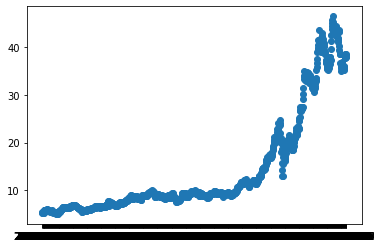

In [48]:
plt.scatter(DataSet['Date'],DataSet['Open'],)
plt.show()

base_treinamento = DataSet.iloc[:, 1:2].values

#DataSet.drop(['Date','Close','High','Low', 'Volume'],axis=1,inplace=True)

In [49]:
base_treinamento

array([[ 5.330769],
       [ 5.388461],
       [ 5.346153],
       ...,
       [38.125   ],
       [37.919998],
       [37.904999]])

### Normalizar os dados da ação

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
DataScaled=scaler.fit_transform(base_treinamento)

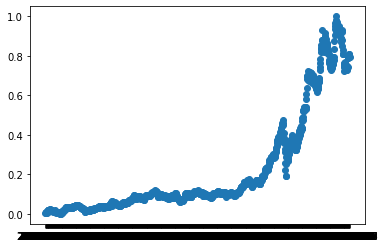

[[0.00594929]
 [0.00734364]
 [0.0063211 ]
 ...
 [0.79855174]
 [0.79359706]
 [0.79323455]]


In [51]:
plt.scatter(DataSet['Date'],DataScaled,)
plt.show()
print(DataScaled)

### Definição dos previsores

In [52]:
previsores = []
preco_real = []
NRecursao = 90
DataSetLen = len(DataScaled) #quantidade de dados no dataset
print(DataSetLen)

1240


In [53]:

for i in range(NRecursao, DataSetLen):
    previsores.append(DataScaled[i-NRecursao:i,0])
    preco_real.append(DataScaled[i,0])

previsores, preco_real = np.array(previsores), np.array(preco_real)

In [54]:
previsores.shape

(1150, 90)

### Tranformar para o formato do Tensor do Keras

<br><img src="TensorKeras.png"><br>

In [55]:
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [56]:
previsores.shape

(1150, 90, 1)

### Estrutura da Rede Neural

In [57]:
# Camada de entrada
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 1)))
regressor.add(Dropout(0.3))

# Cada Oculta 1
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

# Cada Oculta 2
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

# Cada Oculta 3
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

# Camada de Saída
regressor.add(Dense(units = 1, activation = 'linear'))


### Construindo a Rede

In [58]:
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32)

Epoch 1/100
36/36 [==============================] - 11s 88ms/step - loss: 0.0329 - mean_absolute_error: 0.1092
Epoch 2/100
36/36 [==============================] - 3s 88ms/step - loss: 0.0086 - mean_absolute_error: 0.0542
Epoch 3/100
36/36 [==============================] - 3s 88ms/step - loss: 0.0074 - mean_absolute_error: 0.0510
Epoch 4/100
36/36 [==============================] - 3s 88ms/step - loss: 0.0046 - mean_absolute_error: 0.0399
Epoch 5/100
36/36 [==============================] - 3s 88ms/step - loss: 0.0062 - mean_absolute_error: 0.0445
Epoch 6/100
36/36 [==============================] - 3s 88ms/step - loss: 0.0049 - mean_absolute_error: 0.0389
Epoch 7/100
36/36 [==============================] - 3s 88ms/step - loss: 0.0065 - mean_absolute_error: 0.0454
Epoch 8/100
36/36 [==============================] - 3s 87ms/step - loss: 0.0055 - mean_absolute_error: 0.0401
Epoch 9/100
36/36 [==============================] - 3s 87ms/step - loss: 0.0042 - mean_absolute_error: 0.0361


### Conjunto de dados para o Teste

In [59]:
DataSet_teste=pd.read_csv('WEGE3.SA_latest_30_days.csv')

preco_real_teste = DataSet_teste.iloc[:, 1:2].values

base_completa = pd.concat((DataSet['Open'], DataSet_teste['Open']), axis = 0)
entradas = base_completa[len(base_completa) - len(DataSet_teste) - NRecursao:].values

entradas = entradas.reshape(-1, 1)
entradas = scaler.transform(entradas)

In [60]:
DataSetTestLen = len(DataSet_teste)
NPredictions = 90

X_teste = []
for i in range(NRecursao, DataSetTestLen+NRecursao):
    X_teste.append(entradas[i-NRecursao:i, 0])
    
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

previsoes = regressor.predict(X_teste)
previsoes = scaler.inverse_transform(previsoes)


In [61]:
RNN=[]
predictions_teste=X_teste[0].T
predictions_teste=np.reshape(predictions_teste, (predictions_teste.shape[0], predictions_teste.shape[1], 1))

predictions_teste[0][NRecursao-1][0]=regressor.predict(predictions_teste)[0][0]
RNN.append(regressor.predict(predictions_teste)[0])

for i in range(NPredictions-1):
    predictions_teste=np.roll(predictions_teste,-1)
    predictions_teste[0][NRecursao-1][0]=regressor.predict(predictions_teste)[0][0]
    RNN.append(regressor.predict(predictions_teste)[0])
RNN = scaler.inverse_transform(RNN)

print(RNN.mean())
print(previsoes.mean())
print(preco_real_teste.mean())

45.49468176402816
41.691463
35.94549994999999


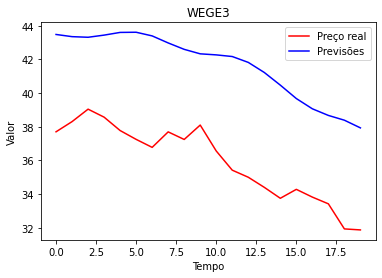

In [64]:
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
#plt.plot(RNN, color = 'green', label = 'RNN')

plt.title('WEGE3')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()